## `AI Generated Text Detection`

In [128]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [76]:
# Load the datasets
train_df = pd.read_csv("llm-detect-ai-generated-text/train_essays.csv")
test_df = pd.read_csv("llm-detect-ai-generated-text/test_essays.csv")

train_prompts = pd.read_csv("llm-detect-ai-generated-text/train_prompts.csv")

In [77]:
train_df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [78]:
# view the prompts in json format
prompts = train_prompts.to_dict()
prompts

{'prompt_id': {0: 0, 1: 1},
 'prompt_name': {0: 'Car-free cities', 1: 'Does the electoral college work?'},
 'instructions': {0: 'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.',
  1: 'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit

In [79]:
# General info
print("train_df info:", train_df.info())
print("-----------------------------")
print("test_df_info:", test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
train_df info: None
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 204.0+ bytes
test_df_info: None


In [80]:
class DataCheck():
    """Missing and dupicated records checks"""
    
    def __init__(self, data):
        """Primary parameters"""
        self.data = data

    def missing_records(self): # Missing records function
        self.missing = self.data.isna().sum()
        return {"Missing Records":self.missing}

    def duplicated_records(self): # Duplicated records function
        self.duplicate = self.data.duplicated().sum()
        return {"Duplicated Records":self.duplicate}

    def outputs(self): # Function to return both outputs above
        return self.missing_records(), self.duplicated_records()

In [81]:
# Inspect the train_df
train_df_checker = DataCheck(train_df)
train_df_checker.outputs()

({'Missing Records': id           0
  prompt_id    0
  text         0
  generated    0
  dtype: int64},
 {'Duplicated Records': 0})

In [82]:
# test_df
test_df_checker = DataCheck(test_df)
test_df_checker.outputs()

({'Missing Records': id           0
  prompt_id    0
  text         0
  dtype: int64},
 {'Duplicated Records': 0})

- `The data is clean for analysis`

### `Data Analysis`

In [83]:
from pandasql import sqldf
pdsql = lambda q:sqldf(q, globals())

# Select where there is 0 for both the id and the target class
query = """SELECT * 
            FROM train_df
            WHERE generated == 0
                AND prompt_id == 0
            LIMIT 10
                ;"""


result = pdsql(query)
print("Length of results:", len(result))
result

Length of results: 10


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
5,01448434,0,"Fellow citizens, cars have become a major role...",0
6,037352a5,0,"""When I had a car I was always tense. I'm much...",0
7,03cabe10,0,Everyone wants to go to the park with their ch...,0
8,03ed46ca,0,There are many advantages to limiting car usag...,0
9,04356693,0,Transportation has become one of the largest e...,0


There is unequal class distribution of the target by [-1372]


Text(0, 0.5, 'Value_Counts')

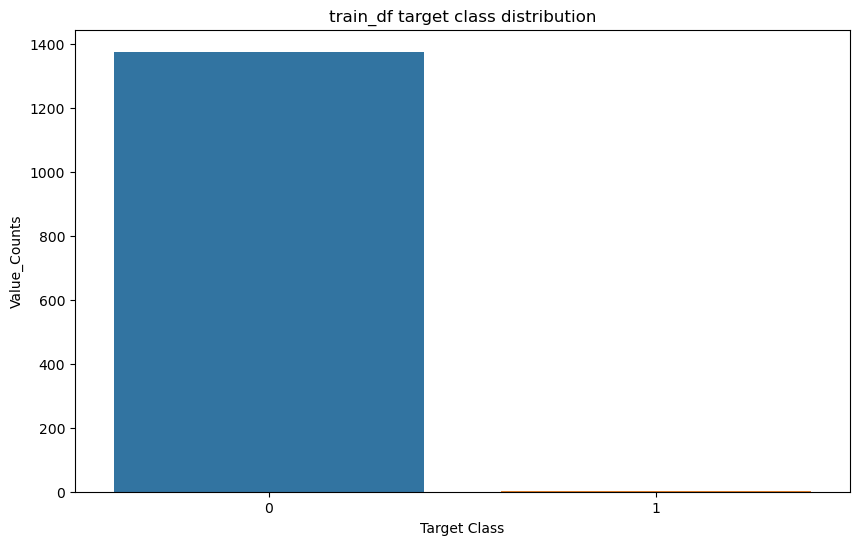

In [84]:
counts = train_df.generated.value_counts()

if counts[0] > counts[1] or counts[1] > counts[0]:
    print("There is unequal class distribution of the target by {}".format(np.diff(counts)))

# Visual
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=counts.index, y=counts.values)
ax.set_title("train_df target class distribution")
ax.set_xlabel("Target Class")
ax.set_ylabel("Value_Counts")

- `feature selection -- the text and the target class`

In [85]:
# Select the columns for text classification
columns = ["text", "generated"]
text_df = train_df[columns]

text_df.head(10)

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
5,The electrol college system is an unfair syste...,0
6,"Dear state senator, It is the utmost respect t...",0
7,"Fellow citizens, cars have become a major role...",0
8,"""It's official: The electoral college is unfai...",0
9,The Electoral College has been kept for centur...,0


`1. Handling Punctuations`

In [86]:
def remove_punc(text):

    # Text lowercase
    text = text.lower()

    # Exclusions
    exclude = string.punctuation
    for character in exclude:
                text = text.replace(character, "")

    return text

# Apply function on the text]
text_df["text"] = text_df["text"].apply(remove_punc)
text_df

/tmp/ipykernel_10477/835141535.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["text"] = text_df["text"].apply(remove_punc)


,text,generated
0,cars cars have been around since they became f...,0
1,transportation is a large necessity in most co...,0
2,americas love affair with its vehicles seems t...,0
3,how often do you ride in a car do you drive a ...,0
4,cars are a wonderful thing they are perhaps on...,0
...,...,...
1373,there has been a fuss about the elector colleg...,0
1374,limiting car usage has many advantages such as...,0
1375,theres a new trend that has been developing fo...,0
1376,as we all know cars are a big part of our soci...,0


`2. Removing URLs - if any`

In [87]:
def cleaning_urls(text):
    # Function for removing urls if any
    return re.sub("((www.[^s]+)|(https?://[^s]+))", " ", text)

# Apply the function to the data
text_df["text"] = text_df["text"].apply(cleaning_urls)

/tmp/ipykernel_10477/3144056192.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["text"] = text_df["text"].apply(cleaning_urls)


`3. Tokenize the text`

In [88]:
def text_tokenizer(text):
    
    # Return the word tokens
    return word_tokenize(text)

# Apply the function on the data
text_df["text"] = text_df["text"].apply(text_tokenizer)
text_df

/tmp/ipykernel_10477/3473979811.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["text"] = text_df["text"].apply(text_tokenizer)


,text,generated
0,"[cars, cars, have, been, around, since, they, ...",0
1,"[transportation, is, a, large, necessity, in, ...",0
2,"[americas, love, affair, with, its, vehicles, ...",0
3,"[how, often, do, you, ride, in, a, car, do, yo...",0
4,"[cars, are, a, wonderful, thing, they, are, pe...",0
...,...,...
1373,"[there, has, been, a, fuss, about, the, electo...",0
1374,"[limiting, car, usage, has, many, advantages, ...",0
1375,"[theres, a, new, trend, that, has, been, devel...",0
1376,"[as, we, all, know, cars, are, a, big, part, o...",0


`4. Remove stopwords`

The stopwords present in the top most frequent words are 13


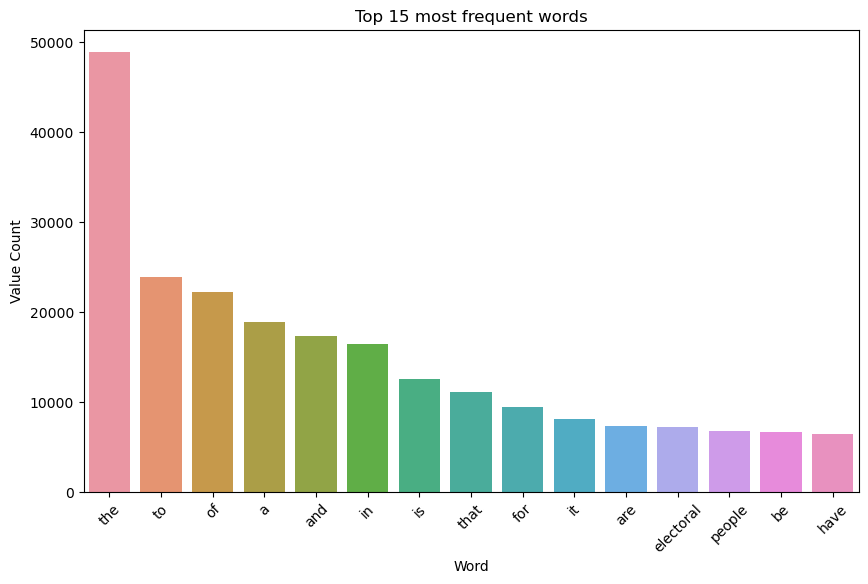

In [93]:
# Stopwords
stopwords_lst = stopwords.words("english")

# Word frequency
def word_freq(text):
    # Top 15 most frequent words
    counts = text.explode().value_counts(ascending=False)[:15]  
    
    # Stopwords present in the data
    stpwords_in_text = [word for word in counts.index if word in stopwords_lst]
    print("The stopwords present in the top most frequent words are {}".format(len(stpwords_in_text)))
    

    # Visualization
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(x=counts.index, y=counts.values)
    ax.set_title("Top 15 most frequent words")
    ax.set_xlabel("Word")
    ax.set_ylabel("Value Count")
    ax.tick_params(axis="x", rotation=45)

word_freq(text_df["text"])

/tmp/ipykernel_10477/3397741620.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["text"] = text_df["text"].apply(stopwords_remover)


The stopwords present in the top most frequent words are 0


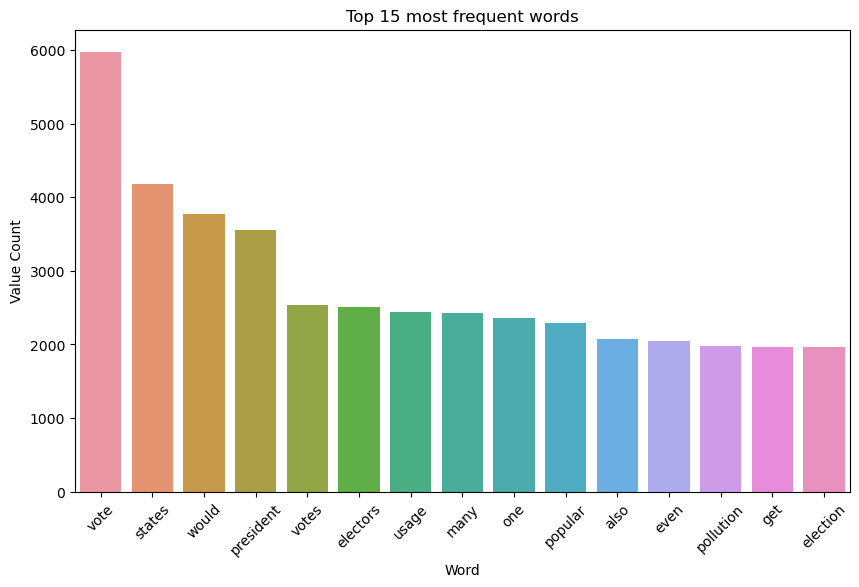

In [99]:
# Remove the stopwords
def stopwords_remover(text):
    # Stopwords
    stopwords_lst = stopwords.words("english")

    custom_stopwords = ["people","car","college"]
    stopwords_lst += custom_stopwords
    text = [word for word in text if word not in stopwords_lst]

    return text

# Apply the function on the data
text_df["text"] = text_df["text"].apply(stopwords_remover)

# Visualize the data for inspection
word_freq(text_df["text"])

`5. Lemmatization`

In [120]:
def text_lemmatizer(text):

    # Instantiate the lemmatizer
    lemmatizer = WordNetLemmatizer()

    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    
    return lemmatized_text

text_df["lemmatized"] = text_df["text"].apply(text_lemmatizer)
text_df.head(10)

/tmp/ipykernel_10477/2776174593.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["lemmatized"] = text_df["text"].apply(text_lemmatizer)


,text,generated,lemmatized
0,"[around, since, became, famous, 1900s, henry, ...",0,"[around, since, became, famous, 1900s, henry, ..."
1,"[transportation, large, necessity, countries, ...",0,"[transportation, large, necessity, country, wo..."
2,"[americas, love, affair, vehicles, seems, cool...",0,"[america, love, affair, vehicle, seems, coolin..."
3,"[often, ride, drive, one, motor, vehicle, work...",0,"[often, ride, drive, one, motor, vehicle, work..."
4,"[wonderful, thing, perhaps, one, worlds, great...",0,"[wonderful, thing, perhaps, one, world, greate..."
...,...,...,...
1373,"[fuss, elector, many, get, confused, works, th...",0,"[fuss, elector, many, get, confused, work, the..."
1374,"[limiting, usage, many, advantages, putting, l...",0,"[limiting, usage, many, advantage, putting, lo..."
1375,"[theres, new, trend, developing, years, soon, ...",0,"[there, new, trend, developing, year, soon, fu..."
1376,"[know, big, part, society, today, however, big...",0,"[know, big, part, society, today, however, big..."


`Word Cloud`
- `a. AI Generated Essays`

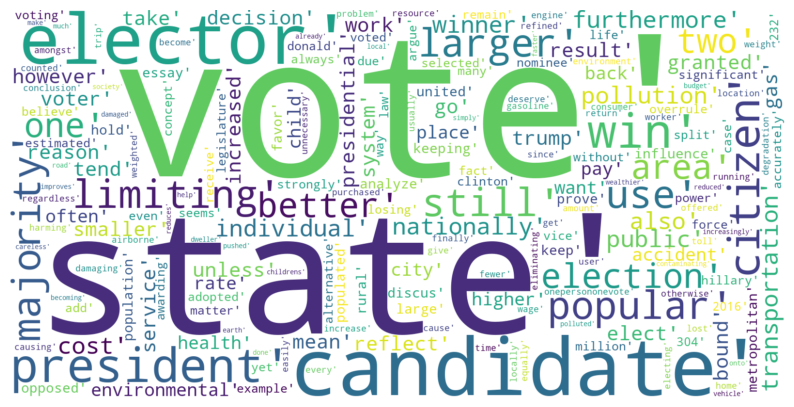

In [126]:
def word_cloud_generator(data, label):
    text = " ".join(str(text) for text in data.loc[data.generated == label].lemmatized)

    word_cloud = WordCloud(background_color="white", 
                           width=1600, 
                           height=800, 
                           min_font_size=5).generate(text)
    
    plt.figure(figsize=(10,6))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# AI generated essays wordcloud
word_cloud_generator(text_df, 1)

`b. Non-generated Essays`

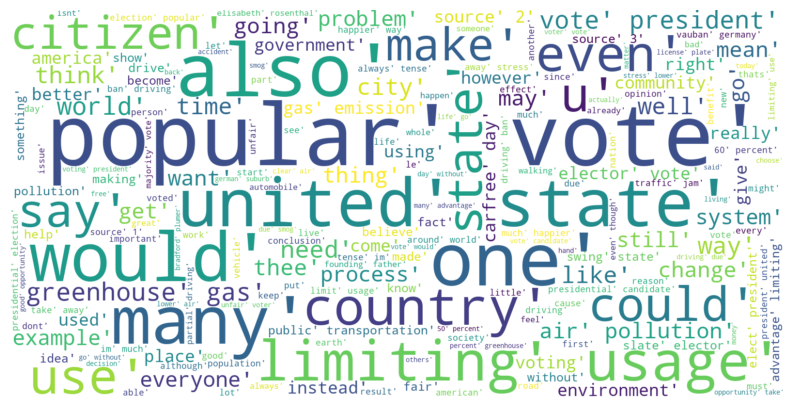

In [127]:
word_cloud_generator(text_df, 0)

### `Data Preprocessing`

`Text Vectorization`